# BPE and Tokenization assignment

This notebook demonstrates:
- Applying BPE on text in English, French, Spanish, and German.
- Computing compression ratios for each language using BPE.
- Computing compression ratios using the GPT tiktoken library and comparing
- Computing the effect of vocabulary size on compression ratio for English, French, Spanish and German.
- Analyzing the effect of file size on the compression ratio for English text.





```
Make use of LLMs like ChatGPT and Claude to help you with code!

You can give a good, detailed prompt and get code for plotting, varying file sizes etc.

Make sure to use the codes we discussed in class also.
```



### Step 1: Install necessary packages
You might need tiktoken and matplotlib


### Step 2: Write BPE code which takes a text file, performs BPE and finds compression ratio.

- You can use the code we discussed in class.

- The dataset files for all languages (English, French, German and Spanish) have been provided to you.

- Note that you can consider the final vocabulary size you can consider = Original vocabulary size  + 200 extra tokens.

### Step 3: Make bar plot of compression ratio for the 4 languages: English, French, German and Spanish.

### Step 4: Use tiktoken library and use tokenization schemes for GPT-2, GPT-3.5 and GPT-4. Find compression ratio for all 4 languages.

### Step 5: Make bar plots to compare compression ratios for BPE, GPT-2, GPT-3.5 and GPT-4 for all 4 languages

In [54]:
# all functions in one place.
import tiktoken
import matplotlib.pyplot as plt
from tabulate import tabulate

def get_file_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

def get_character_tokens(file_path):
    text = get_file_text(file_path)
    char_tokens = [ord(ch) for ch in text]
    ids = list(char_tokens)
    max_id = max(ids)
    return ids, max_id

def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1
    return counts

def merge(ids, pair, idx):
    newids = []
    i = 0
    while i < len(ids):
        if i < len(ids) - 1 and ids[i] == pair[0] and ids[i + 1] == pair[1]:
            newids.append(idx)
            i += 2
        else:
            newids.append(ids[i])
            i += 1
    return newids

def merg_token_ids(token_ids,num_merges, max_id):
    for i in range(num_merges):
        # 1) Count all adjacent pairs in our current sequence 'ids'.
        stats = get_stats(token_ids)
        pair = max(stats, key=stats.get)
        idx = max_id + i
        # Decode the characters of the pair for display
        char_pair = (chr(pair[0]), chr(pair[1]))
        token_ids = merge(token_ids, pair, idx)
    return token_ids

def print_compression_ratio(model, language, char_tokens_ids, merged_token_ids, extra_tokens):
    comp_ratio = len(char_tokens_ids) / len(merged_token_ids)
    print(f"{model}-{language} extra tokens: {extra_tokens}")
    print(f"{model}-{language} char tokens length: {len(char_tokens_ids)}")
    print(f"{model}-{language} merged token ids length: {len(merged_token_ids)}")
    print(f"{model}-{language} compression ratio: {comp_ratio:.4f}X")
    print("......................................\n")
    return comp_ratio

def draw_bar_graph(axs,labels, values, title, xlabel, ylabel):
    axs.bar(labels, values, color='skyblue')
    axs.set_title(title)
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)

def get_token_ids(ids,max_id,file_path, model, extra_tokens):
    text = get_file_text(file_path)
    if model == "BPE":
        token_ids = merg_token_ids(ids, extra_tokens, max_id)
    else:
        tokenizer = tiktoken.encoding_for_model(model)
        token_ids = tokenizer.encode(text)
    return token_ids

def compute_comp_ratio_matrix(models, lang, files, extra_tokens):
    temp_comp_ratios = []
    # all model, all language comp ratios. rows = english, french, german, spanish. col = bpe, gpt2, gpt3, gpt4.
    comp_ratios_matrix = []
    for i in range(0, len(lang)):
        ids, max_id = get_character_tokens(files[i])
        for j in range(0, len(models)):
            temp_comp_ratios.append(print_compression_ratio(models[j], lang[i], ids, get_token_ids(ids,max_id,files[i], models[j],extra_tokens), extra_tokens))
        comp_ratios_matrix.append(temp_comp_ratios)
        temp_comp_ratios = []

    return comp_ratios_matrix

def visualize_comp_ratios_matrix(models, lang, comp_ratios_matrix):
    num_cols = max(len(lang), len(models))
    fig, axs = plt.subplots(nrows=2, ncols=num_cols, figsize=(20, 10))
    axs=axs.flatten()
    for i in range(0, len(lang)):
        # drawing the compression ratio bar graph for each language, across all models.
        draw_bar_graph(axs[i],models, comp_ratios_matrix[i], f"Comp Ratios for {lang[i]} across all Models", "Models", "Compression Ratio")
    graphCount=i
    for columnIndex in range(0, len(models)):
        ratiosPerModel = [row[columnIndex] for row in comp_ratios_matrix]
        # drawing the compression ratio bar graph for each model, across all languages.
        graphCount+=1
        draw_bar_graph(axs[graphCount],lang, ratiosPerModel, f"Comp Ratios for Model {models[columnIndex]} across all Lang", "Languages", "Compression Ratio")
    plt.tight_layout()
    plt.show()

def heatmap(lang, models, comp_ratios_matrix, extra_tokens):
    import seaborn as sns
    import matplotlib.pyplot as plt
    print (f"Number of extra tokens = {extra_tokens}")
    # Define row and column labels
    row_labels = lang
    col_labels = models

    # Create a heatmap
    sns.heatmap(comp_ratios_matrix, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5, xticklabels=col_labels, yticklabels=row_labels)

    # Add axis labels
    plt.xlabel("Models")
    plt.ylabel("Languages")
    plt.title("Heatmap of compression ratios")

    # Display the plot
    plt.show()

def print_comp_ratios_matrix(comp_ratios_matrix, extra_tokens, models, lang):
    print (f"Compression ratio matrix across all languages and models for number of extra tokens = {extra_tokens}\n")
    print(tabulate(comp_ratios_matrix, headers=models, showindex=lang, tablefmt="fancy_grid"))


In [55]:
lang = ["English", "French", "German", "Spanish"]
files = ["./input.txt", "./output_french.txt", "./output_german.txt", "./output_spanish.txt"]
models = ["BPE", "gpt2", "gpt-3.5-turbo", "gpt-4"]
extra_tokens = 1
comp_ratios_matrix = compute_comp_ratio_matrix(models, lang, files, extra_tokens)

BPE-English extra tokens: 1
BPE-English char tokens length: 1115394
BPE-English merged token ids length: 1087751
BPE-English compression ratio: 1.0254X
......................................

gpt2-English extra tokens: 1
gpt2-English char tokens length: 1115394
gpt2-English merged token ids length: 338025
gpt2-English compression ratio: 3.2997X
......................................

gpt-3.5-turbo-English extra tokens: 1
gpt-3.5-turbo-English char tokens length: 1115394
gpt-3.5-turbo-English merged token ids length: 301829
gpt-3.5-turbo-English compression ratio: 3.6955X
......................................

gpt-4-English extra tokens: 1
gpt-4-English char tokens length: 1115394
gpt-4-English merged token ids length: 301829
gpt-4-English compression ratio: 3.6955X
......................................

BPE-French extra tokens: 1
BPE-French char tokens length: 1244159
BPE-French merged token ids length: 1197140
BPE-French compression ratio: 1.0393X
...................................

In [56]:
print_comp_ratios_matrix(comp_ratios_matrix, extra_tokens, models, lang)

Compression ratio matrix across all languages and models for number of extra tokens = 1

╒═════════╤═════════╤═════════╤═════════════════╤═════════╕
│         │     BPE │    gpt2 │   gpt-3.5-turbo │   gpt-4 │
╞═════════╪═════════╪═════════╪═════════════════╪═════════╡
│ English │ 1.02541 │ 3.29974 │         3.69545 │ 3.69545 │
├─────────┼─────────┼─────────┼─────────────────┼─────────┤
│ French  │ 1.03928 │ 2.47434 │         3.25856 │ 3.25856 │
├─────────┼─────────┼─────────┼─────────────────┼─────────┤
│ German  │ 1.02901 │ 2.38823 │         3.31644 │ 3.31644 │
├─────────┼─────────┼─────────┼─────────────────┼─────────┤
│ Spanish │ 1.0247  │ 2.42158 │         3.19973 │ 3.19973 │
╘═════════╧═════════╧═════════╧═════════════════╧═════════╛


Number of extra tokens = 1


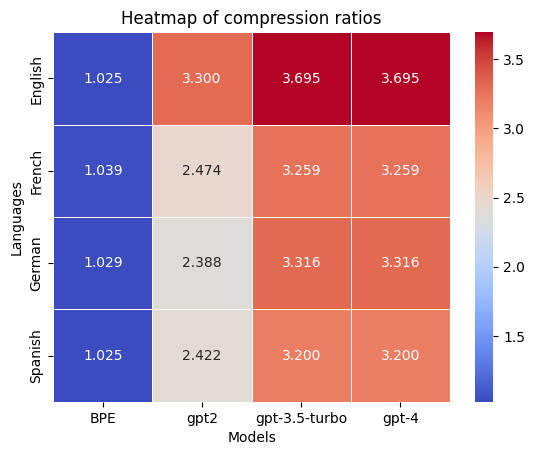

In [57]:
heatmap(lang, models, comp_ratios_matrix, extra_tokens)

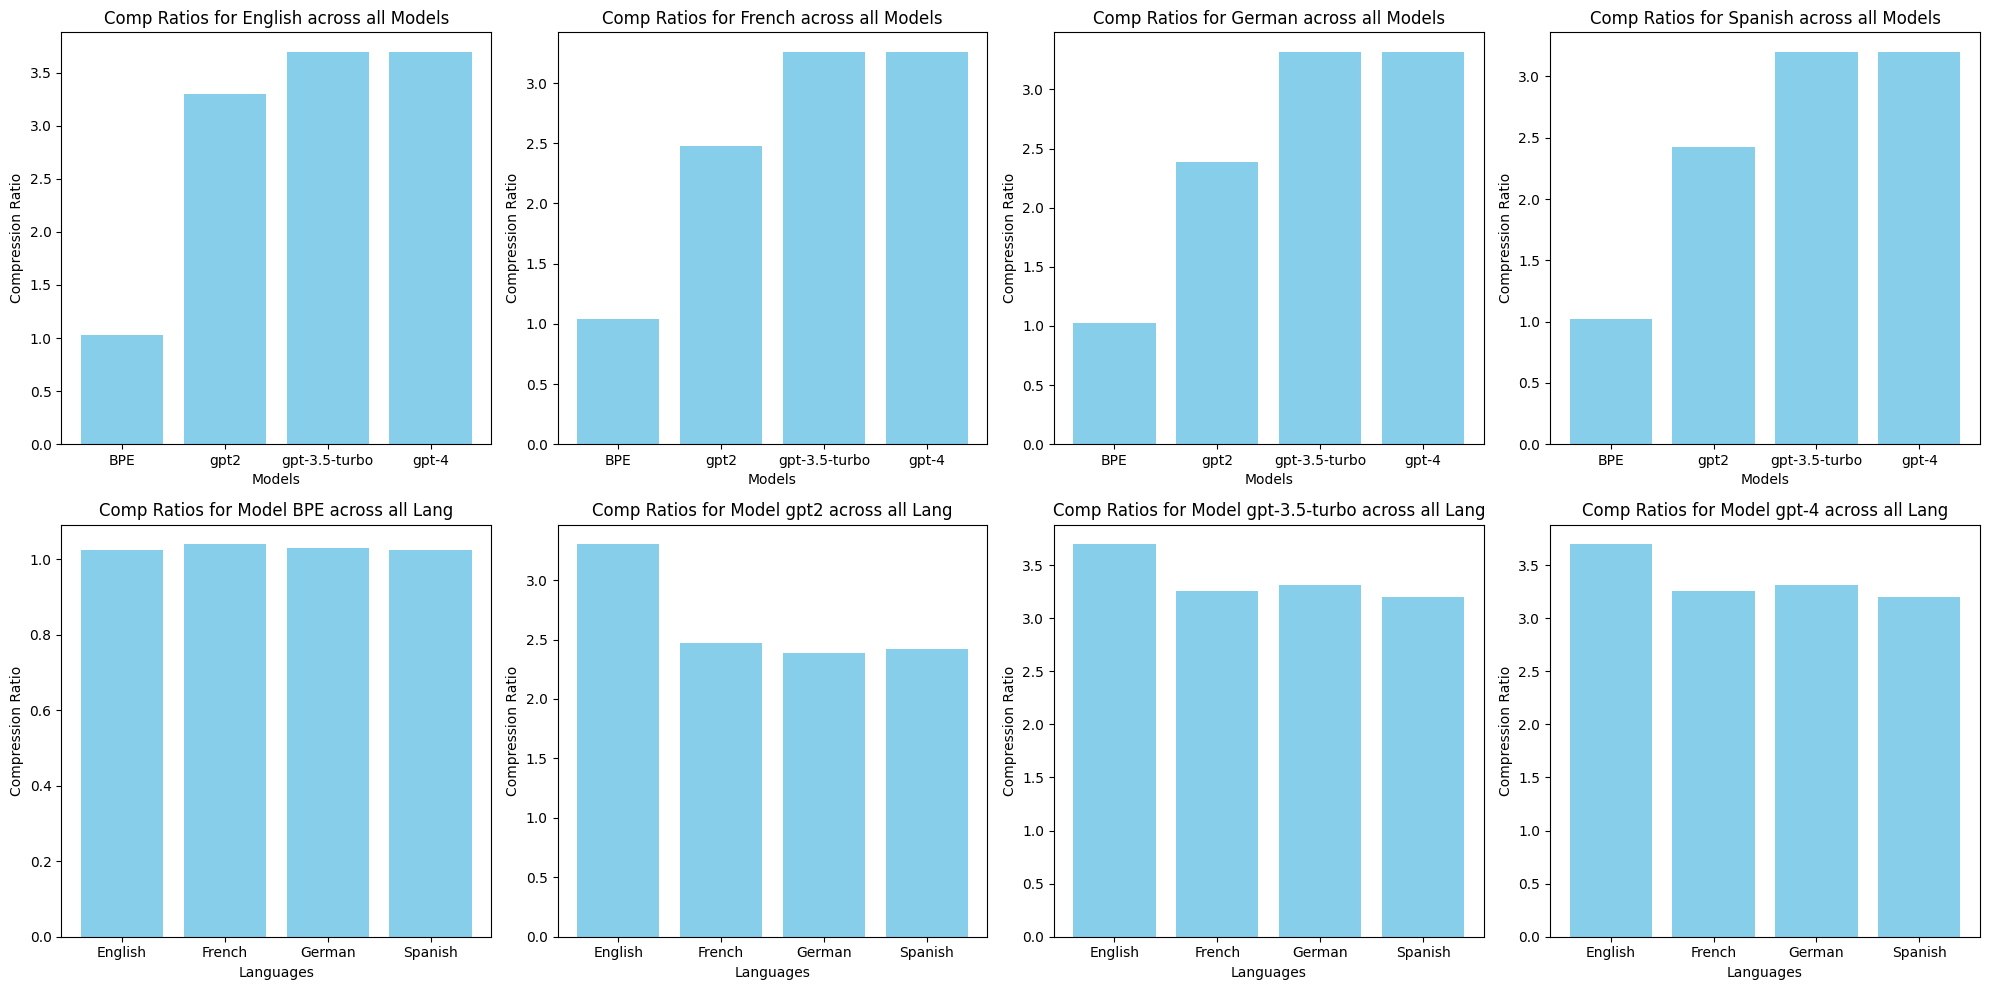

In [58]:
visualize_comp_ratios_matrix(models, lang, comp_ratios_matrix)

### Step 6: Vary the extra tokens from 200 to 500 to 800. Write code to find effect of extra tokens on the compression ratio. Do this for all languages

Hint: You already have written the BPE code for extra tokens = 200 in Step 2. Use this as reference.

In [59]:
# effect of extra tokens on compression ratio
extra_tokens = [1, 2, 3]
lang = ["English"]
files = ["./input.txt"]
models = ["BPE", "gpt2", "gpt-3.5-turbo", "gpt-4"]
comp_ratios_extra_tokens = []
for merges in extra_tokens:
    comp_ratios_extra_tokens+=(compute_comp_ratio_matrix(models, lang, files, merges)) 


BPE-English extra tokens: 1
BPE-English char tokens length: 1115394
BPE-English merged token ids length: 1087751
BPE-English compression ratio: 1.0254X
......................................

gpt2-English extra tokens: 1
gpt2-English char tokens length: 1115394
gpt2-English merged token ids length: 338025
gpt2-English compression ratio: 3.2997X
......................................

gpt-3.5-turbo-English extra tokens: 1
gpt-3.5-turbo-English char tokens length: 1115394
gpt-3.5-turbo-English merged token ids length: 301829
gpt-3.5-turbo-English compression ratio: 3.6955X
......................................

gpt-4-English extra tokens: 1
gpt-4-English char tokens length: 1115394
gpt-4-English merged token ids length: 301829
gpt-4-English compression ratio: 3.6955X
......................................

BPE-English extra tokens: 2
BPE-English char tokens length: 1115394
BPE-English merged token ids length: 1065012
BPE-English compression ratio: 1.0473X
...............................

In [60]:
print (comp_ratios_extra_tokens)

[[1.0254129851409008, 3.2997381850454848, 3.695450072723297, 3.695450072723297], [1.0473065092224314, 3.2997381850454848, 3.695450072723297, 3.695450072723297], [1.0637956555244426, 3.2997381850454848, 3.695450072723297, 3.695450072723297]]


In [61]:
print (f"Extra tokens matrix across all languages and models for compression ratio = {extra_tokens}\n")
print(tabulate(comp_ratios_extra_tokens, headers=models, showindex=extra_tokens, tablefmt="fancy_grid"))

Extra tokens matrix across all languages and models for compression ratio = [1, 2, 3]

╒════╤═════════╤═════════╤═════════════════╤═════════╕
│    │     BPE │    gpt2 │   gpt-3.5-turbo │   gpt-4 │
╞════╪═════════╪═════════╪═════════════════╪═════════╡
│  1 │ 1.02541 │ 3.29974 │         3.69545 │ 3.69545 │
├────┼─────────┼─────────┼─────────────────┼─────────┤
│  2 │ 1.04731 │ 3.29974 │         3.69545 │ 3.69545 │
├────┼─────────┼─────────┼─────────────────┼─────────┤
│  3 │ 1.0638  │ 3.29974 │         3.69545 │ 3.69545 │
╘════╧═════════╧═════════╧═════════════════╧═════════╛


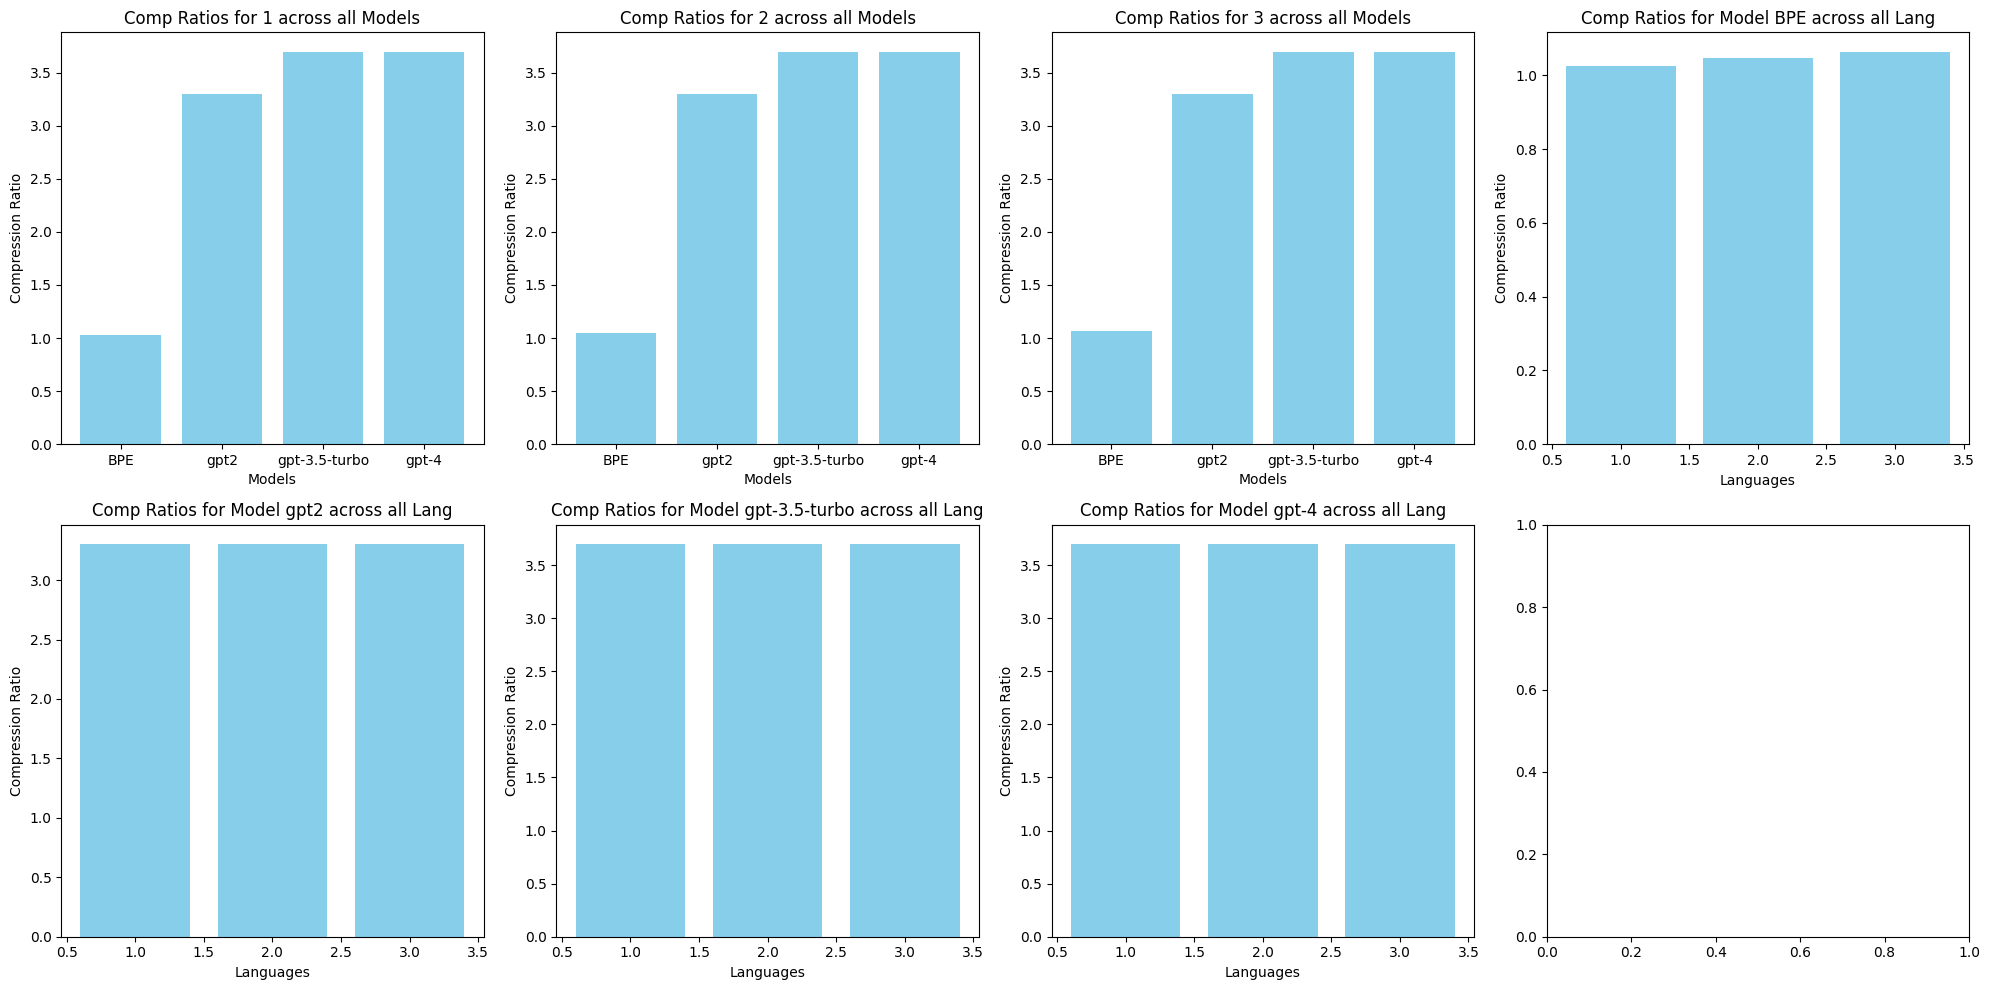

In [62]:
visualize_comp_ratios_matrix(models, extra_tokens, comp_ratios_extra_tokens)

## Step 5: Make bar plots to compare compression ratios for BPE, GPT-2, GPT-3.5 and GPT-4 for all 4 languages

## Step 5: Make bar plots to compare compression ratios for BPE, GPT-2, GPT-3.5 and GPT-4 for all 4 languages

## Step 5: Make bar plots to compare compression ratios for BPE, GPT-2, GPT-3.5 and GPT-4 for all 4 languages

## Step 5: Make bar plots to compare compression ratios for BPE, GPT-2, GPT-3.5 and GPT-4 for all 4 languages

## Step 7: Write code for varying input file size and see effect on compression ratio (only for English language).

- Create text files with decreasing sizes using the scaling factors: 10, 8, 6.

- Note that the final vocabulary size you can consider = Original vocabulary size + 5% of the total text size.

Hint: Here is how you can use scaling factor of let's say 10.


```
fraction = 1 / 10

subtext = input_text[:int(len_text * fraction)]
```



In [11]:
## Your code here. Feel free to use ChatGPT, Claude for help.